In [3]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
from Manifold_Analysis import Manifold_analysis
sys.path.append('../../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame


# importing required libraries
from mpl_toolkits.mplot3d import Axes3D



from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

import cv2

In [ ]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

## Init GPU or CPU

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Create Environment

In [28]:
#env = gym.make('SpaceInvaders-v0',render_mode='human')
env = gym.make('SpaceInvaders-v0')


env.seed(0)

def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Create Agent

In [29]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

start_epoch = 0
scores = []
scores_window = deque(maxlen=20)
length_trial = 500

In [30]:
agent_init = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_1000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_2000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_3000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_4000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)


Liste_agents = {
    "agent_init" : agent_init,
    "agent_1000" : agent_1000,
    "agent_2000" : agent_2000,
    "agent_3000" : agent_3000,
    "agent_4000" : agent_4000
}



## Load Agents corresponding to different part of the training

In [31]:
for a in Liste_agents.keys():
    if a != "agent_init":
        
        PATH = os.path.join(os.getcwd(),"Models_training_dqn_space_invader",a+ ".pt")
        print(PATH)
        checkpoint = torch.load(PATH , map_location=torch.device('cpu'))
        Liste_agents[a].policy_net.load_state_dict(checkpoint['modelA_state_dict'])
        Liste_agents[a].target_net.load_state_dict(checkpoint['modelB_state_dict'])
        Liste_agents[a].optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_dqn_space_invader/agent_1000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_dqn_space_invader/agent_2000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_dqn_space_invader/agent_3000.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_dqn_space_invader/agent_4000.pt


In [32]:
Names_hook = ["fc1","Conv_1","Conv_2","Conv_3"]
EPISODES = 10
Liste_activation = [[[[] for i in range(len(Names_hook))] for j in range(len( Liste_agents))] for episode in range(EPISODES)]
i = 0

for episode in range(EPISODES):
    agent_number = 0
    for agent in Liste_agents.values():
        while i < length_trial:
            agent.registration()
            score = 0
            #print(Liste_activation[agent_number])
            
            Liste_activation[episode][agent_number] = [[] for i in range(len(Names_hook))]
            state = stack_frames(None, env.reset(), True)
            i = 0

            while True:
                #env.render()
                action = agent.act(state)

                for h in range(len(Names_hook)):
                    #print(torch.flatten(agent.activation[Names_hook[h]]).unsqueeze(0).size())
                    Liste_activation[episode][agent_number][h].append(torch.flatten(agent.activation[Names_hook[h]]))  # If concatenate list directly with Liste_activation[agent_number][h] += torch.flatten(agent.activation[Names_hook[h]]) takes much more time
        
                next_state, reward, done, _ = env.step(action)
                score += reward
                state = stack_frames(state, next_state, False)
                

    
                i +=1
                if done:
                    print('\nEpisode :{} \tAgent number :{} \tFinal score: {:.2f} \tNumber of steps: {}'.format(episode,agent_number, score,i), end="")
        
                    break 
            env.close()


            agent.detach()
        i = 0   

        agent_number += 1
        

    


Episode :0 	Agent number :0 	Final score: 0.00 	Number of steps: 924
Episode :0 	Agent number :1 	Final score: 90.00 	Number of steps: 510
Episode :0 	Agent number :2 	Final score: 285.00 	Number of steps: 1019
Episode :0 	Agent number :3 	Final score: 35.00 	Number of steps: 948
Episode :0 	Agent number :4 	Final score: 190.00 	Number of steps: 692
Episode :1 	Agent number :0 	Final score: 0.00 	Number of steps: 921
Episode :1 	Agent number :1 	Final score: 125.00 	Number of steps: 771
Episode :1 	Agent number :2 	Final score: 180.00 	Number of steps: 624
Episode :1 	Agent number :3 	Final score: 0.00 	Number of steps: 376
Episode :1 	Agent number :3 	Final score: 0.00 	Number of steps: 386
Episode :1 	Agent number :3 	Final score: 0.00 	Number of steps: 671
Episode :1 	Agent number :4 	Final score: 90.00 	Number of steps: 523
Episode :2 	Agent number :0 	Final score: 0.00 	Number of steps: 934
Episode :2 	Agent number :1 	Final score: 110.00 	Number of steps: 677
Episode :2 	Agent n

In [33]:
analysis = Manifold_analysis(length_trial)

## Compute the Isomap

agent_number 0
agent_number 1
agent_number 2


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarnin

agent_number 3


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)


agent_number 4


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarnin

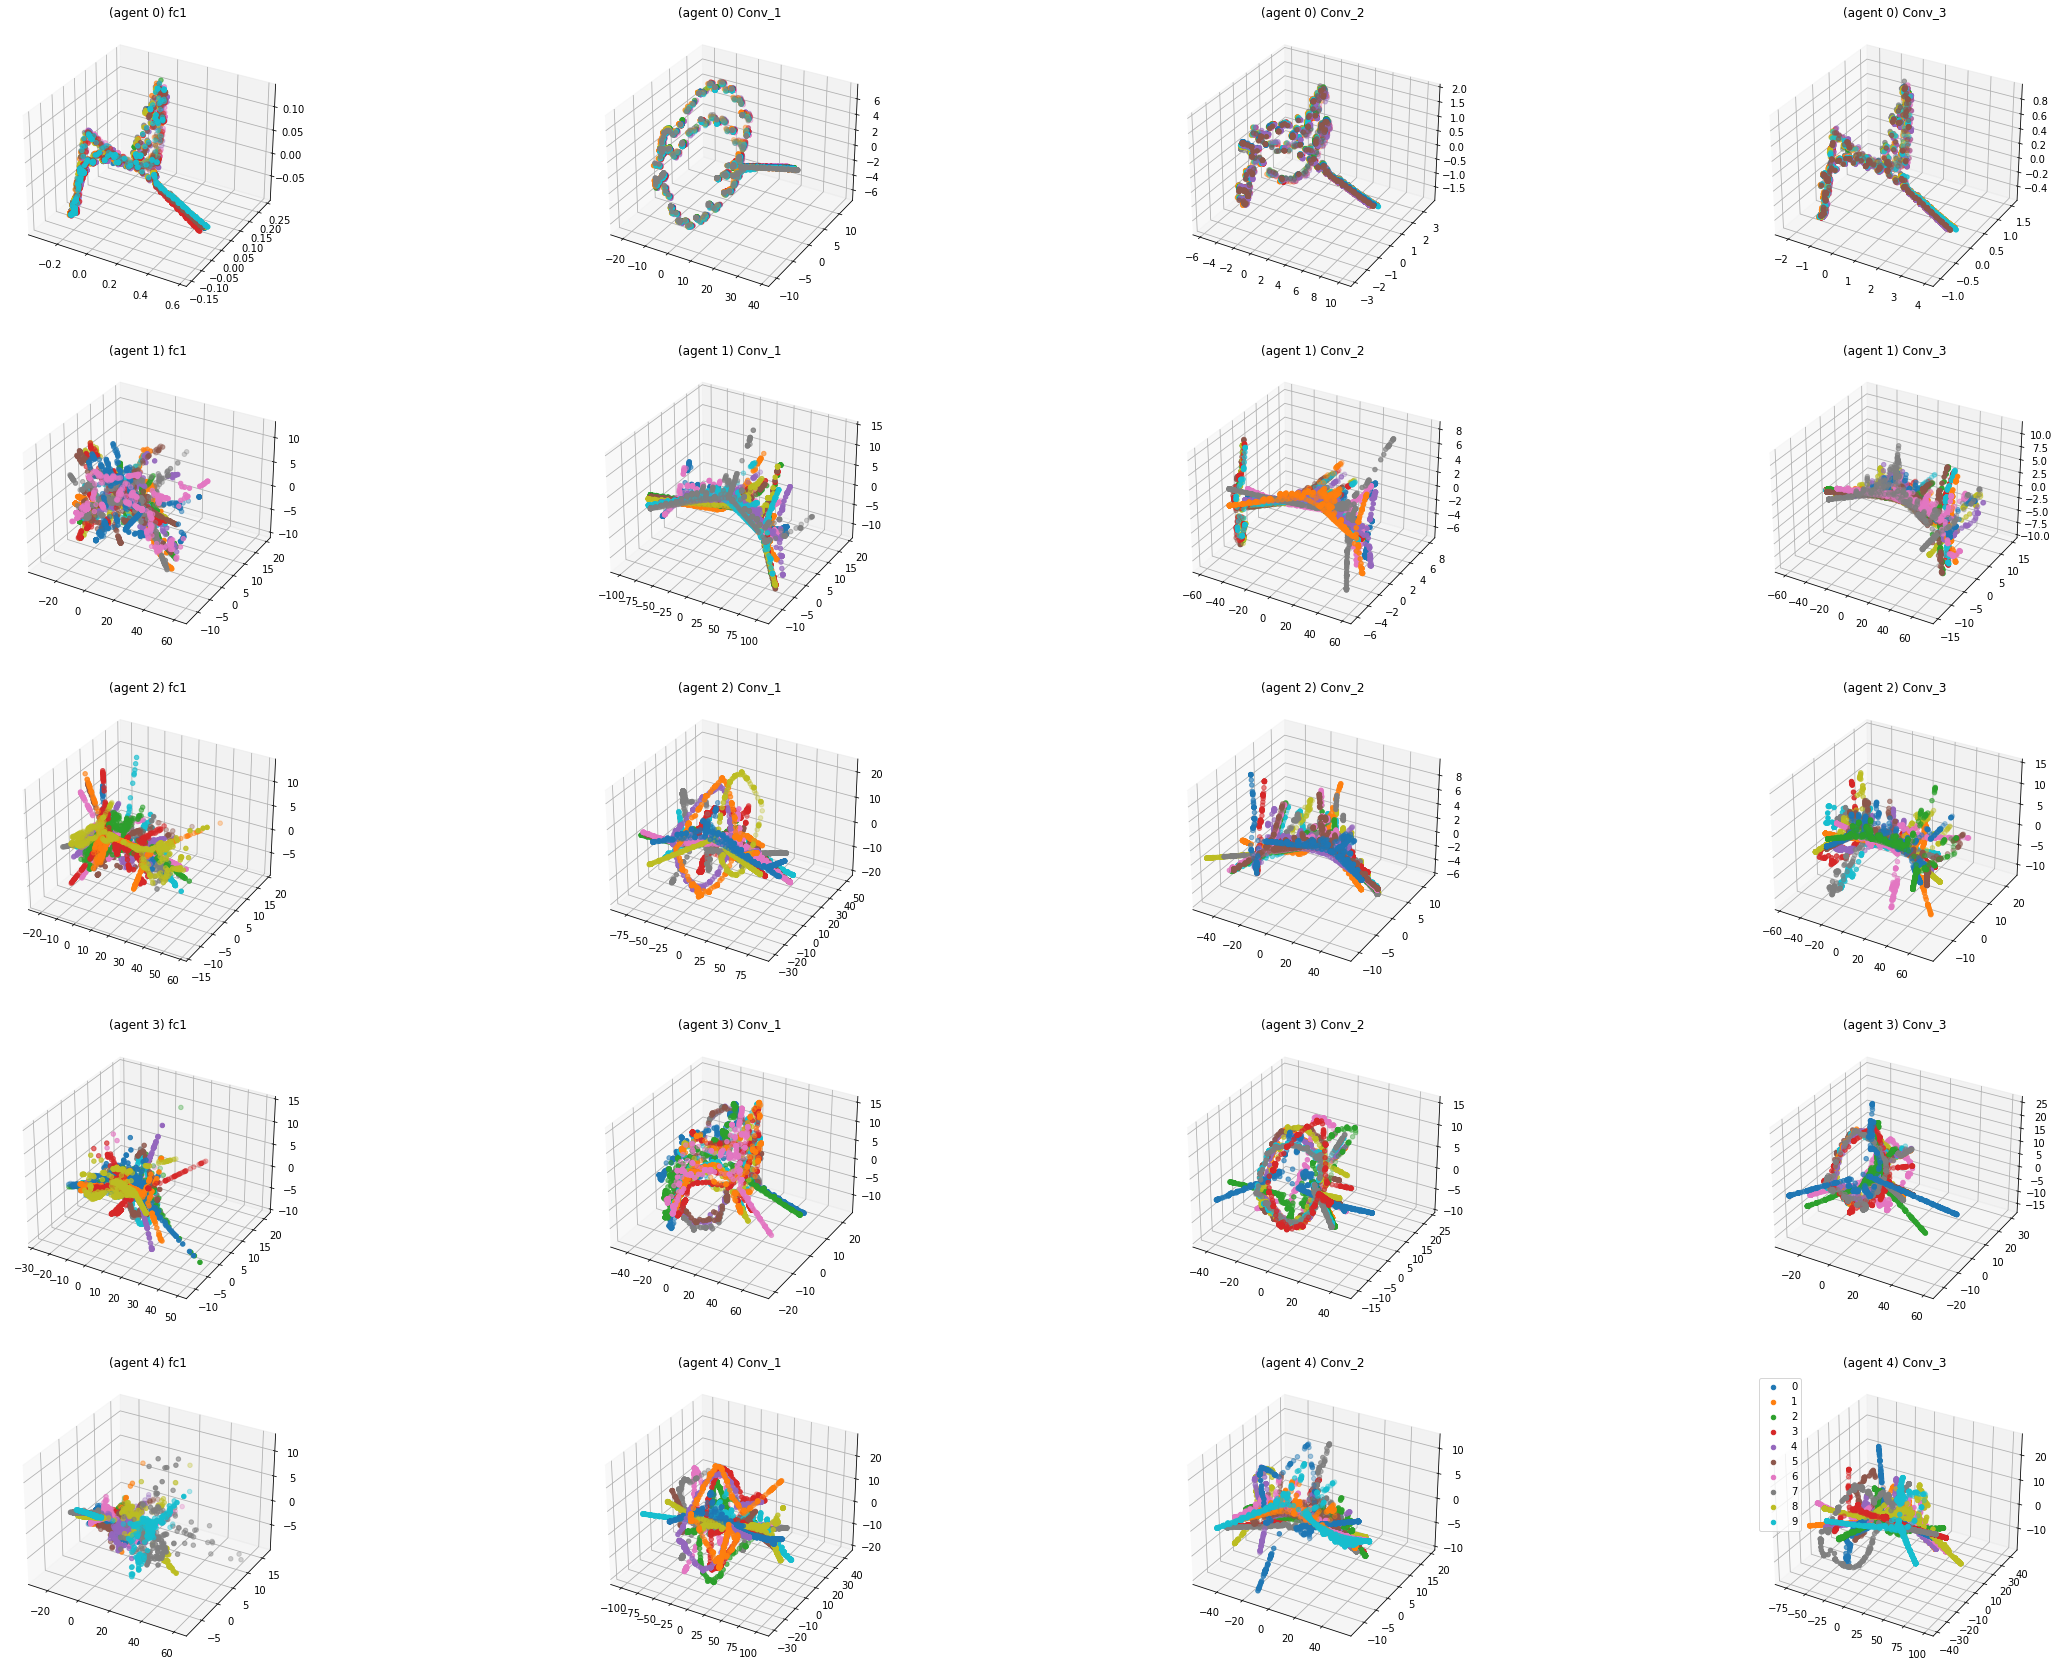

In [34]:
embedding = Isomap(n_neighbors=15,n_components=3)
i = 1
fig = plt.figure(figsize=(40, 30))

for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        #ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))
        for episode in range(EPISODES):
            activity_layer = analysis.prepro(Liste_activation[episode][agent_number][layer])
            X = embedding.fit_transform(activity_layer)
            #colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
            ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],label = episode)
        #ax.view_init(azim=80, elev=30)
        
        i+=1
plt.legend(loc='upper left')
plt.show()



## MDS plot

In [ ]:
D = pairwise_distances(activation)
model = MDS(n_components=dimension, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

agent_number 0
agent_number 1
agent_number 2
agent_number 3


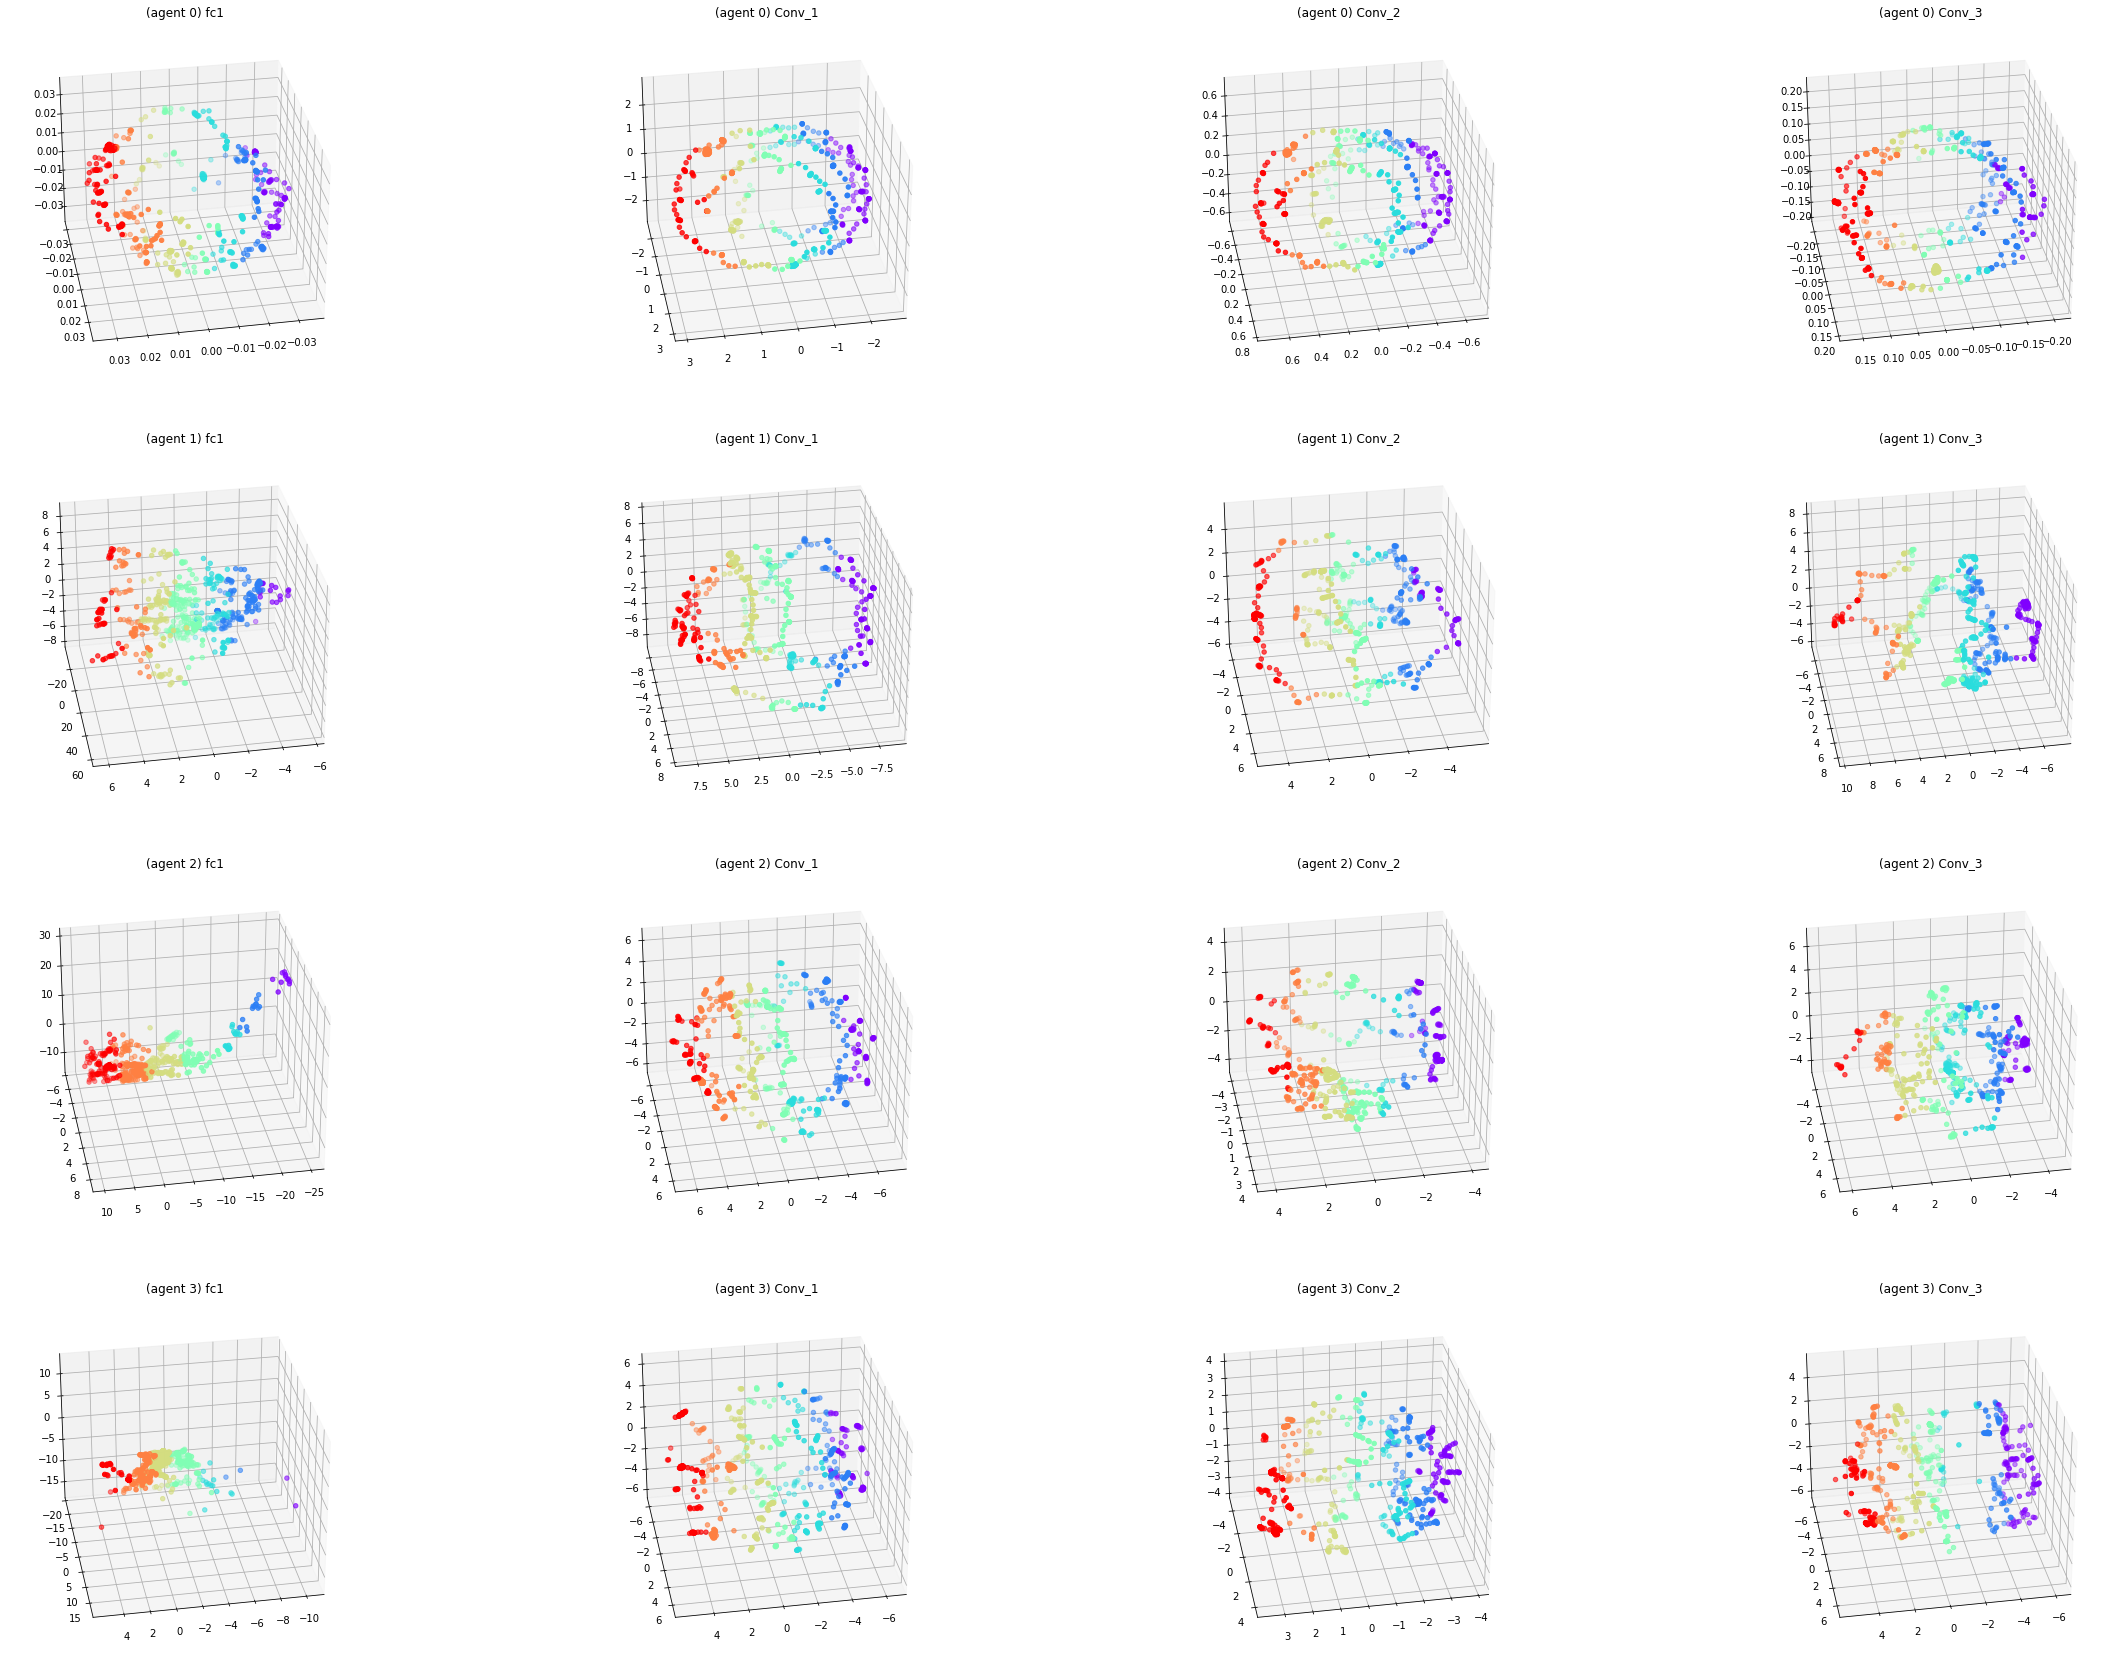

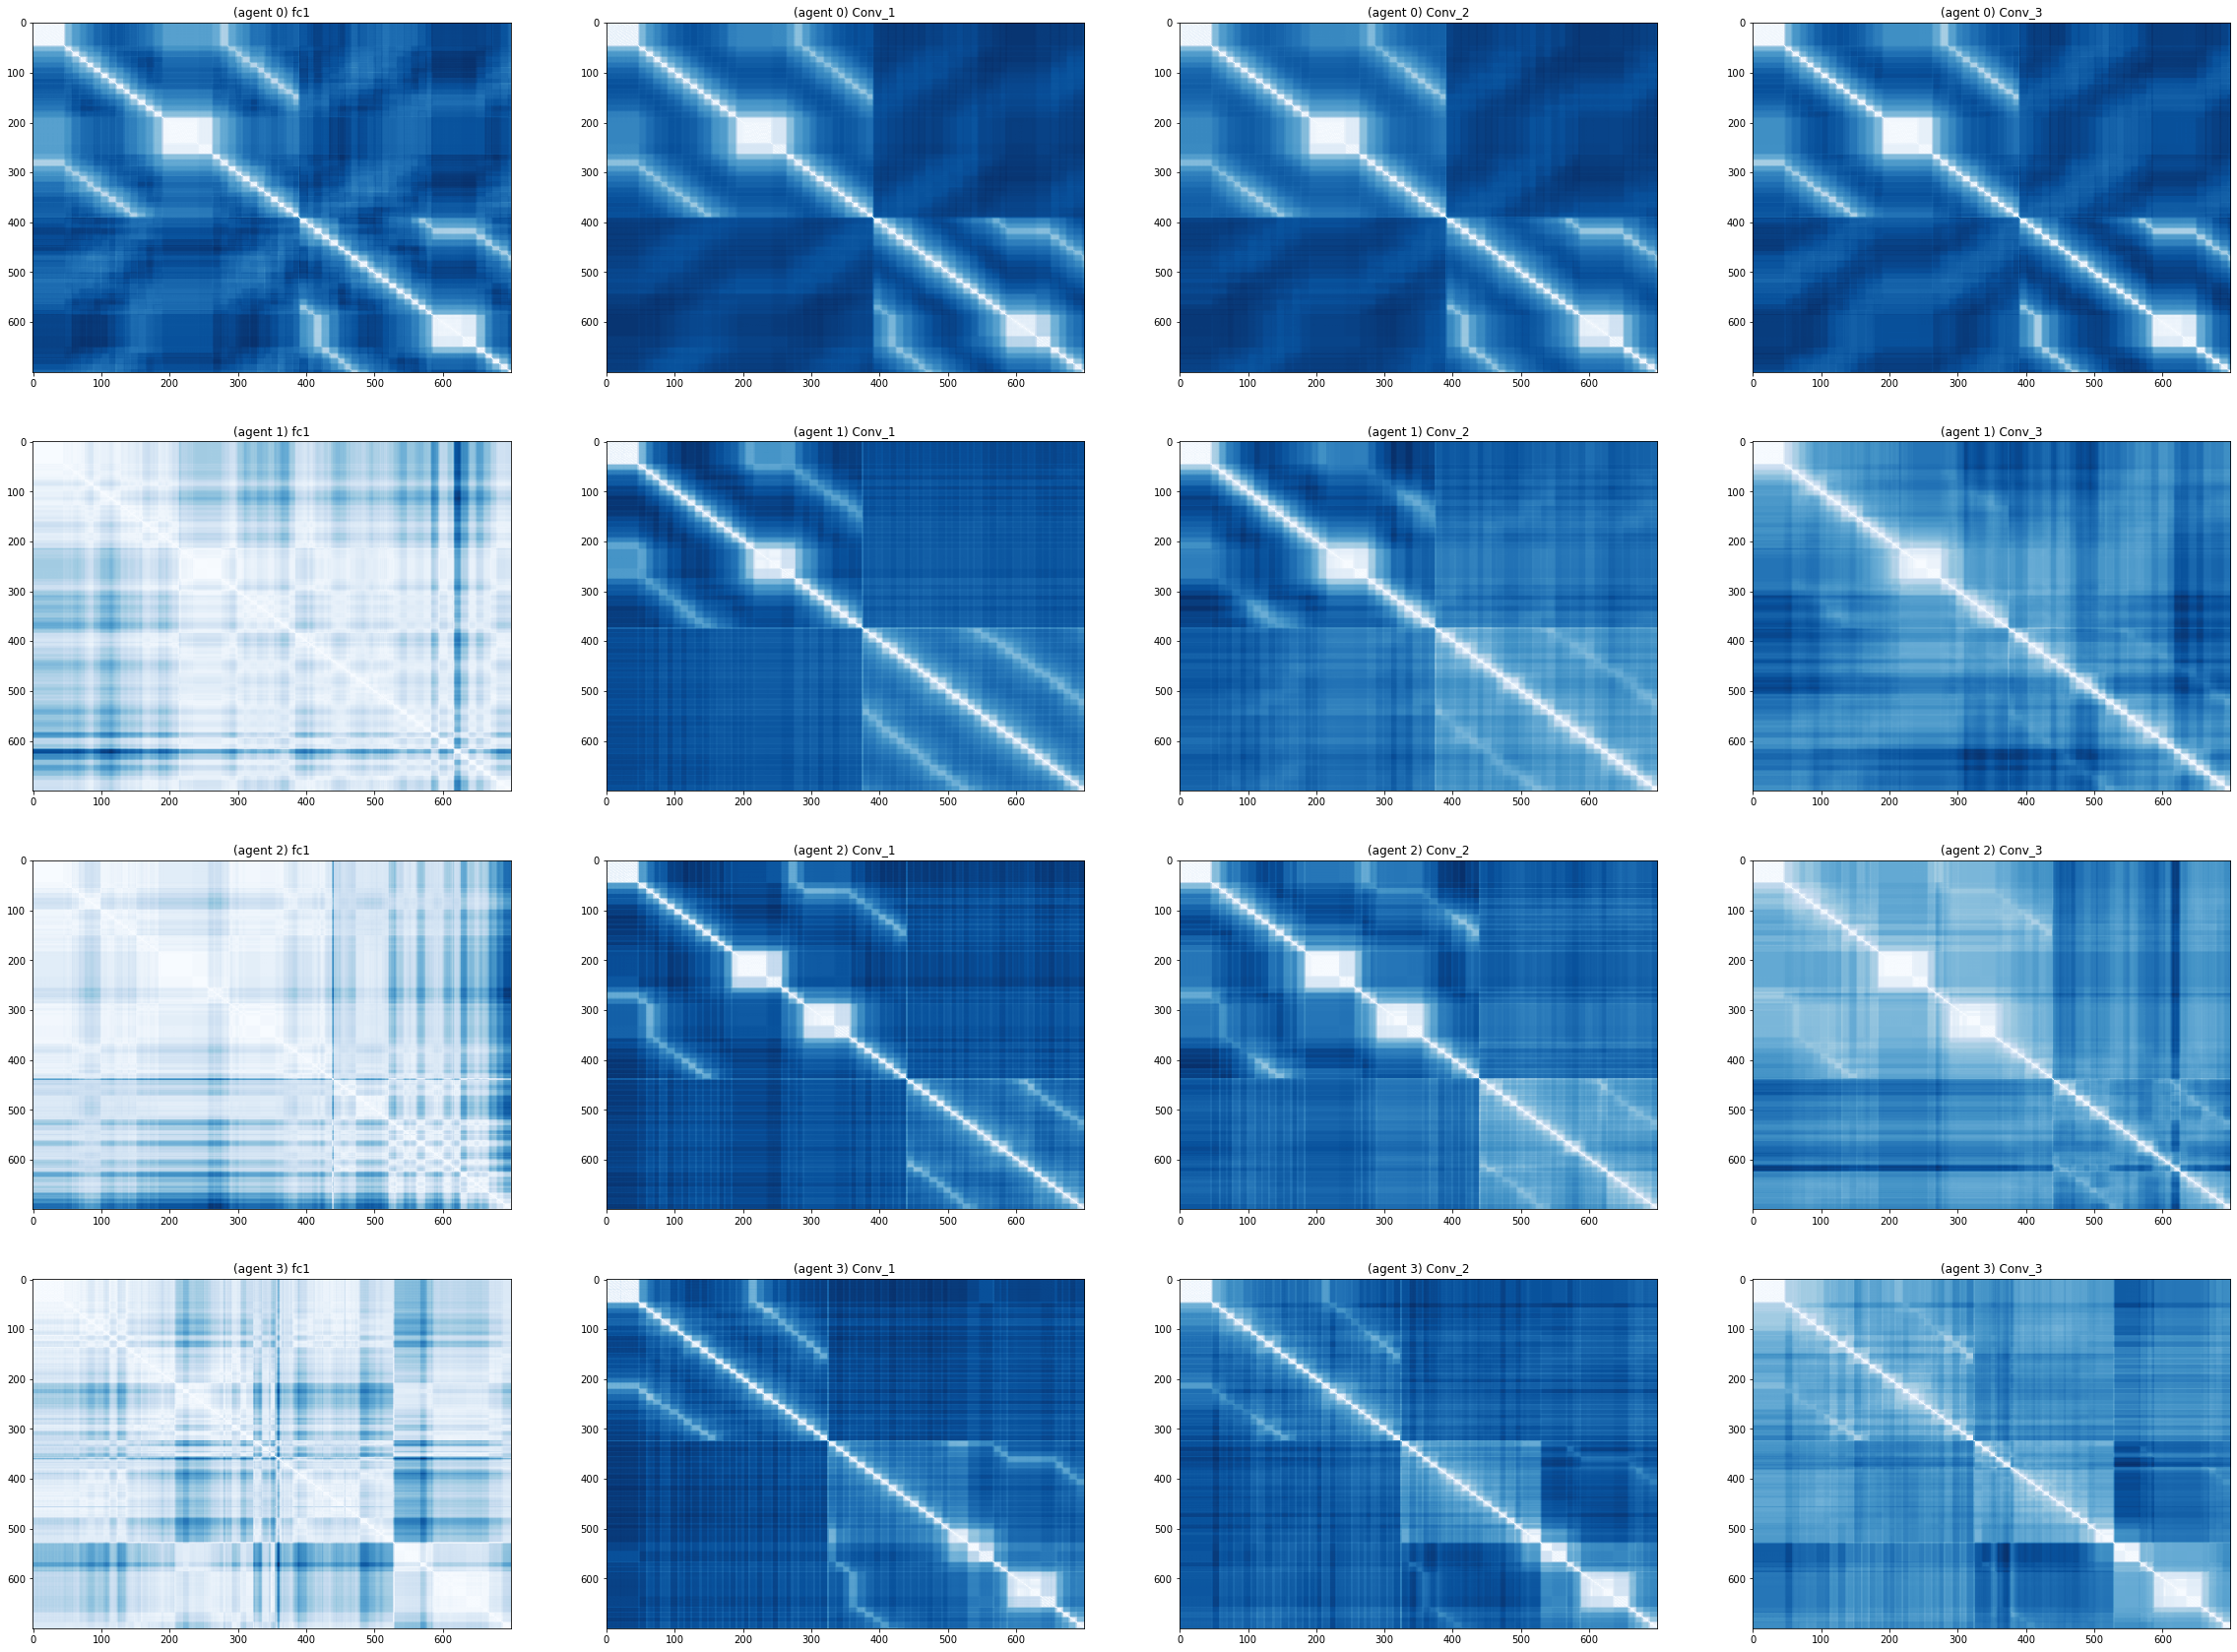

In [36]:

model = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
i = 1
fig = plt.figure(figsize=(40, 30))

fig2 = plt.figure(figsize=(40, 30))
for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        activity_layer = analysis.prepro(Liste_activation[agent_number][layer])

        D = pairwise_distances(activity_layer)
        X  = model.fit_transform(D)
        colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],**colorize)
        ax.view_init(azim=80, elev=30)
        ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))

        ax2 = fig2.add_subplot(len(Liste_agents), len(Names_hook),i)
        ax2.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
        ax2.axis("tight")
        ax2.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))






        i+=1
plt.show()

## t-SNE

agent_number 0


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 1


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 2


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

agent_number 3


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:79

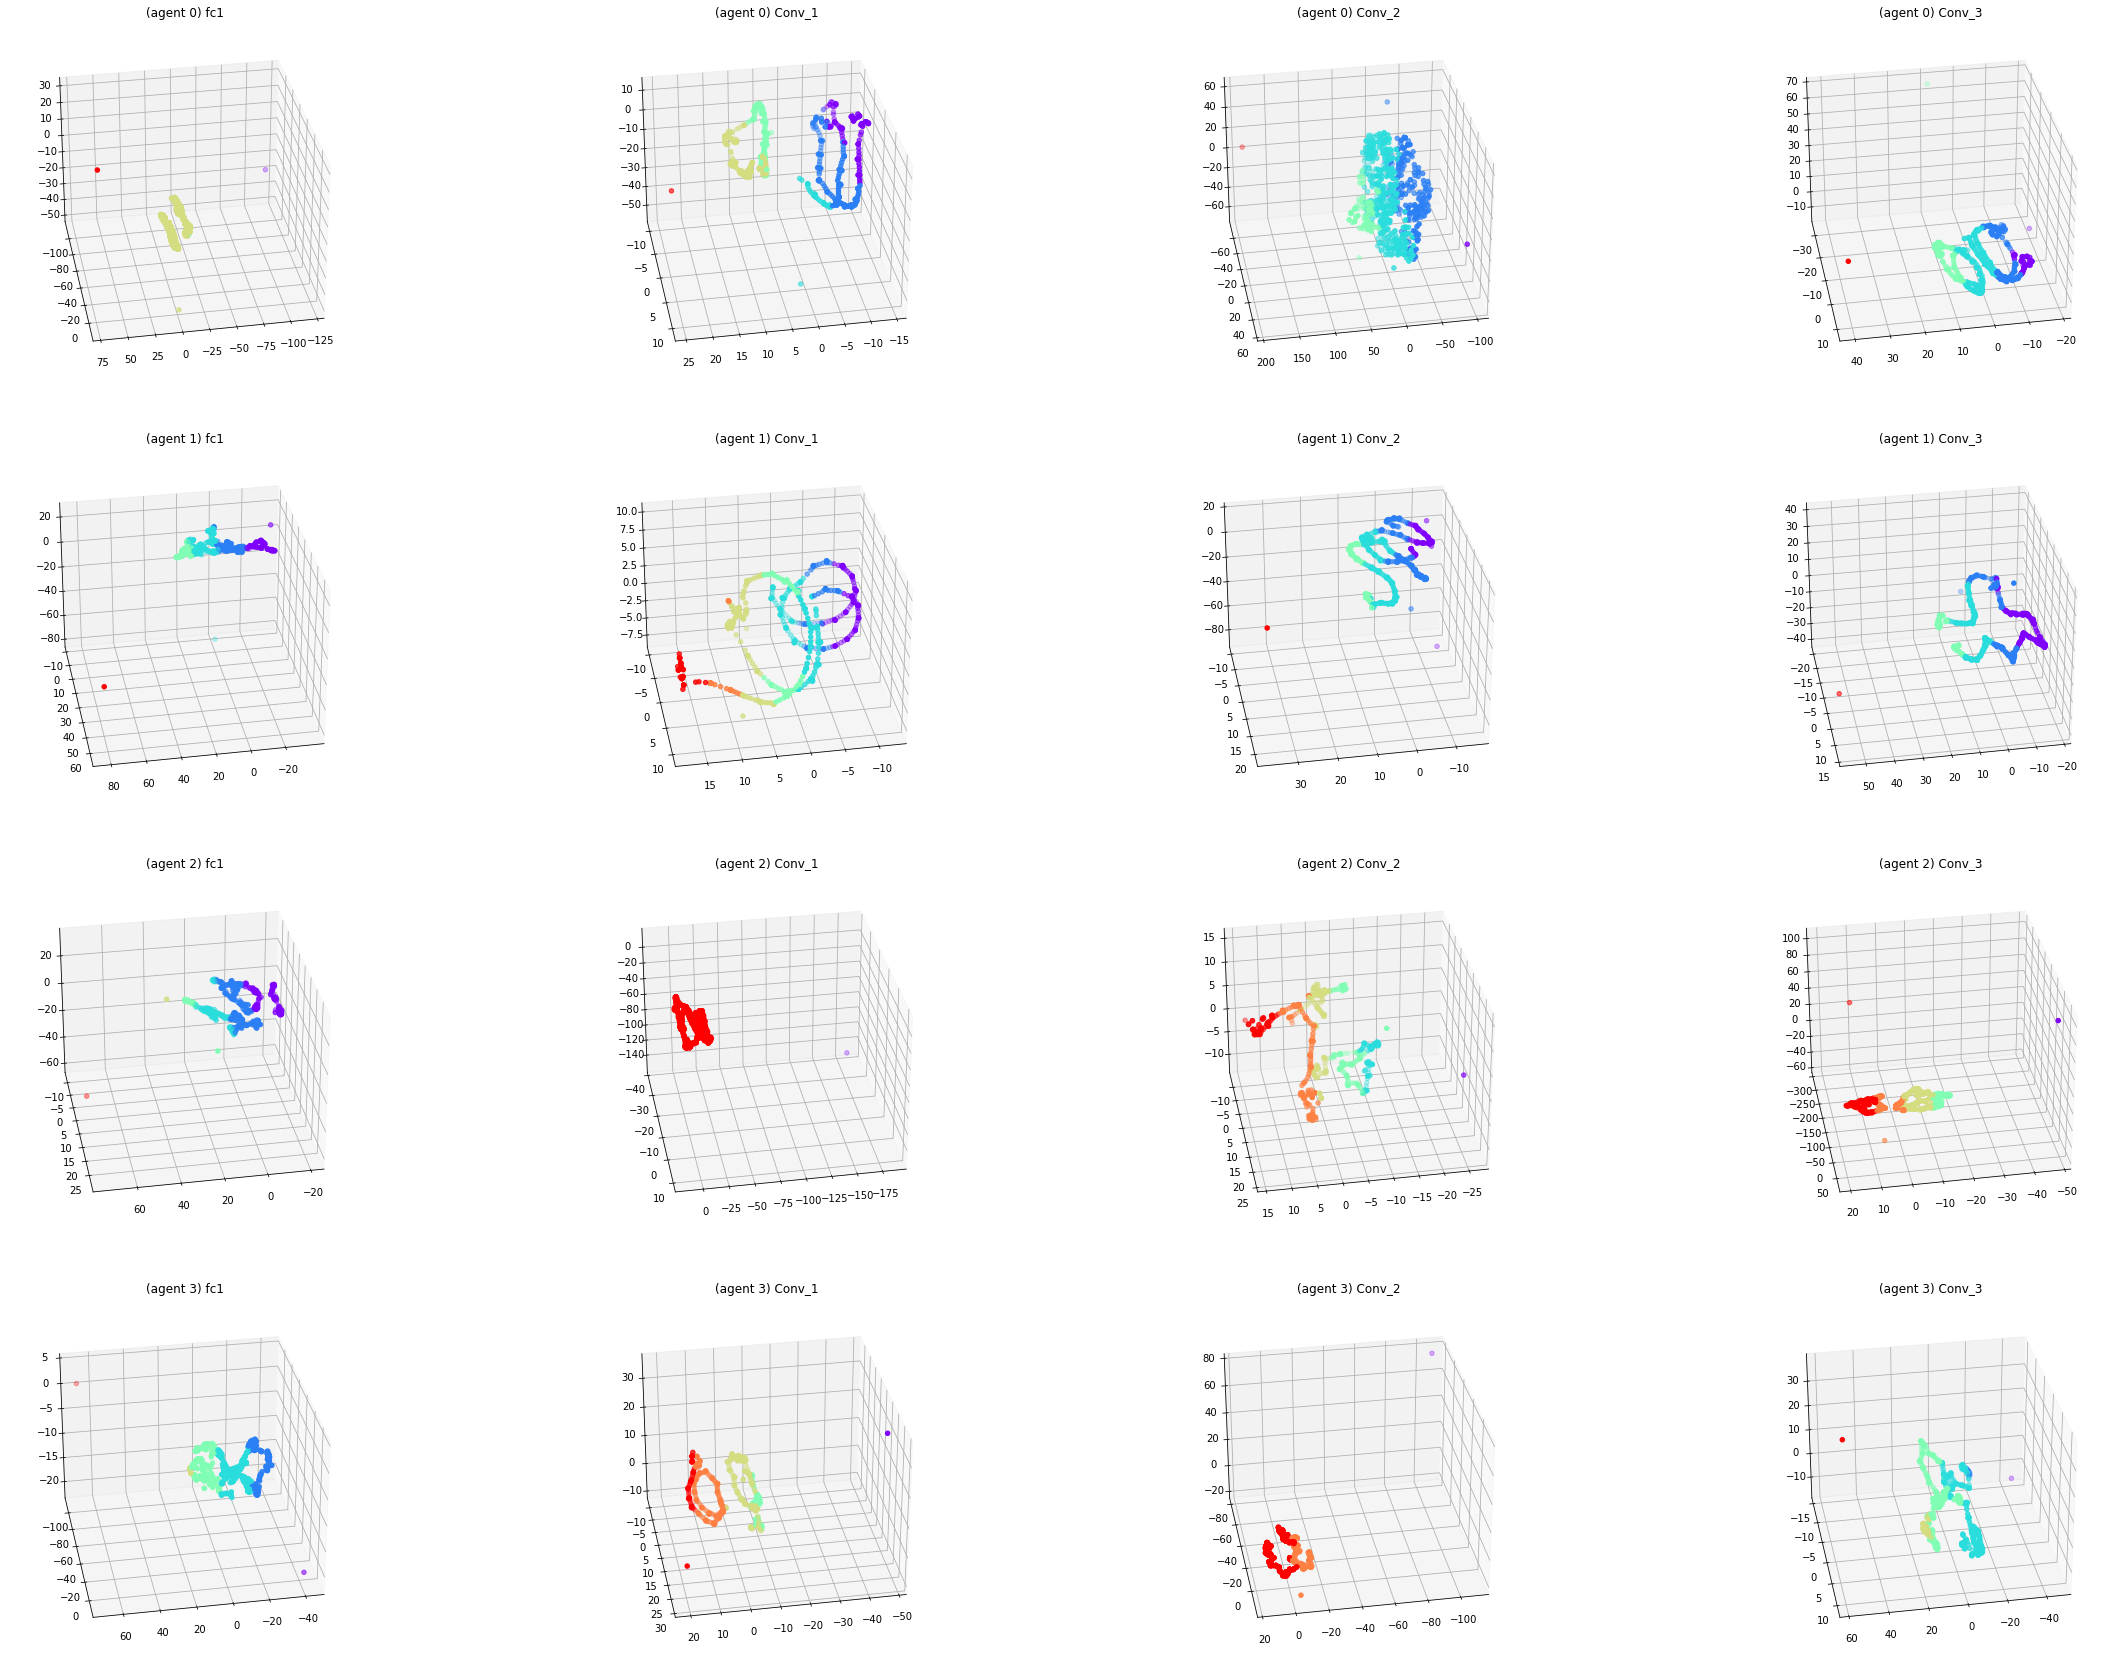

In [33]:
model = manifold.TSNE(n_components=3, init="pca", random_state=0)

i = 1
fig = plt.figure(figsize=(40, 30))
for agent_number in range(len(Liste_agents)):
    print("agent_number",agent_number)
    for layer in range(len(Names_hook)):
        activity_layer = analysis.prepro(Liste_activation[agent_number][layer])
        X  = model.fit_transform(activity_layer)
        colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
        ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        sc = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],**colorize)
        ax.view_init(azim=80, elev=30)
        ax.axis("tight")
        ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))
        i+=1
plt.show()

In [37]:
a = torch.tensor([2,3,4])
b = torch.tensor([2,3,4])

print(a+b)

tensor([4, 6, 8])
